In [1]:
import numpy as np
import pandas as pd
import pywt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def wavelet_top_p_denoise(x, wavelet="db4", level=None, top_p=0.2):
    """
    Drop the lowest-energy *detail coefficients* until their cumulative energy
    reaches `top_p` of total detail energy. top_p in [0,1].
    top_p=0 -> keep all details (minimal smoothing)
    top_p=1 -> drop all details (keep only approximation; maximal smoothing)
    """
    x = np.asarray(x, dtype=float)
    w = pywt.Wavelet(wavelet)
    max_level = pywt.dwt_max_level(len(x), w.dec_len)
    L = min(level if level is not None else 8, max_level) if max_level > 0 else 1

    coeffs = pywt.wavedec(x, w, mode="symmetric", level=L)
    cA, details = coeffs[0], coeffs[1:]

    top_p = float(np.clip(top_p, 0.0, 1.0))
    if top_p <= 0 or len(details) == 0:
        y = pywt.waverec(coeffs, w, mode="symmetric")
        return y[:len(x)]
    if top_p >= 1.0:
        zeros = [np.zeros_like(d) for d in details]
        y = pywt.waverec([cA] + zeros, w, mode="symmetric")
        return y[:len(x)]

    # Gather all detail coeff energies (squared magnitudes) across levels
    energies = [d.flatten()**2 for d in details]
    energies_flat = np.concatenate(energies)
    total_energy = energies_flat.sum()
    if total_energy == 0:
        y = pywt.waverec(coeffs, w, mode="symmetric")
        return y[:len(x)]

    # Find energy cutoff so that we drop the lowest-energy coefficients
    # up to 'top_p' fraction of total detail energy
    sort_idx = np.argsort(energies_flat)                    # ascending energy
    cumsum_energy = np.cumsum(energies_flat[sort_idx])
    cutoff_idx = np.searchsorted(cumsum_energy, top_p * total_energy, side="right")
    cutoff_energy = energies_flat[sort_idx[min(cutoff_idx, len(sort_idx)-1)]]

    # Zero coefficients with energy <= cutoff across all levels
    pruned_details = []
    for d in details:
        mask = (d**2) <= cutoff_energy
        pruned_details.append(np.where(mask, 0.0, d))

    y = pywt.waverec([cA] + pruned_details, w, mode="symmetric")
    return y[:len(x)]

# --- Data ---
df = pd.read_csv(
    "./raw_data/VOO_60min_splits_only_standard.csv",
    parse_dates=["timestamp"],
    index_col="timestamp",
).sort_index()
df = df[(df.index >= "2013-01-01") & (df.index < "2025-01-01")]

# --- Series ---
close = df["close"]
volume = df["volume"]
# volume_ema = volume.ewm(span=5).mean()

vol_wv_p099 = pd.Series(
    wavelet_top_p_denoise(volume.to_numpy(), wavelet="dmey", level=None, top_p=0.5),
    index=df.index, name="Wavelet top_p=0.4"
)

# --- Plot ---
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index, y=close, name="Close Price"), secondary_y=False)
# fig.add_trace(
#     go.Scatter(x=df.index, y=volume_ema, name="Volume (EMA)", line=dict(color="orange")),
#     secondary_y=True,
# )

fig.add_trace(go.Scatter(x=df.index, y=vol_wv_p099, name=vol_wv_p099.name), secondary_y=True)

fig.update_layout(title_text="Close Price and Volume (EMA vs Wavelet top_p)")
fig.update_xaxes(title_text="Date", type="category", tickmode="linear", tick0=0, dtick=50)
fig.update_yaxes(title_text="Close Price", secondary_y=False)
fig.update_yaxes(title_text="Volume", secondary_y=True)
fig.show()


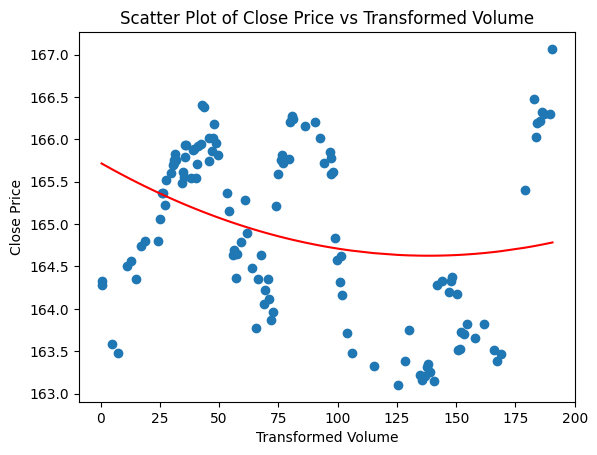

In [53]:
import numpy as np
import pandas as pd

df = pd.read_csv('./raw_data/VOO_60min_splits_only_standard.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index()
sample_len = 123
sample = df.iloc[1345:1345+sample_len]  # take a sample from the end

close = sample['close'].to_numpy()
volume = sample['volume'].to_numpy()

log_vol = np.log(volume)
vol_mean = np.mean(log_vol)
vol_std = np.std(log_vol)

z = np.exp((log_vol - vol_mean) / vol_std)

z = np.cumsum(z)


poly = np.polyfit(z, close, deg=2)

from matplotlib import pyplot as plt

plt.scatter(z, close)
plt.plot(z, np.polyval(poly, z), color='red')
plt.xlabel('Transformed Volume')
plt.ylabel('Close Price')
plt.title('Scatter Plot of Close Price vs Transformed Volume')
plt.show()